In [1]:
import os
import argparse
import logging
import sys
import json
import numpy as np

import torch
from torch.optim.lr_scheduler import StepLR
import torchtext

os.chdir(os.path.dirname(os.path.abspath(os.path.dirname(os.path.abspath(os.path.dirname('__file__'))))))

from models.seq2seq import Seq2seq
from loss.loss import Perplexity
from evaluator.evaluator import Evaluator
from dataset import fields

import matplotlib.pyplot as plt

In [2]:
log_level = 'info'
LOG_FORMAT = '%(asctime)s %(levelname)-6s %(message)s'
logging.basicConfig(format=LOG_FORMAT, level=getattr(logging, log_level.upper()))

In [3]:
f1_score_lists = []
data_name = "copy"
dir_name = "separator_Ctype4_30"
dev_name = "separator_Ctype4_60"
pretrained_dir_name = None
rnn = "lstm"
iterator = list(range(1,11,1))

data_path = "data/"+data_name+"_rand/correction_"+dir_name
dev_data_path = "data/"+data_name+"_rand/correction_"+dev_name
train_path = data_path+"/data_train.txt"
config_path = "models/config.json"

In [4]:
for i in iterator:
        print("RNN is %s" % rnn)
        print("data path: %s" % data_path)
        f1_score_list = []

        # Prepare dataset
        max_len = 65
        src = fields.SourceField()
        srcp = fields.SourceField()
        tgt = fields.TargetField()
        tgtp = fields.TargetField()
        def len_filter(example):
            return len(example.src) <= max_len and len(example.tgt) <= max_len
        train = torchtext.data.TabularDataset(
            path=train_path, format='tsv',
            fields=[('src', src), ('tgt', tgt)],
            filter_pred=len_filter
        )
        src.build_vocab(train)
        tgt.build_vocab(train)
        input_vocab = src.vocab
        output_vocab = tgt.vocab

        print("src vocab size = %d" % (len(src.vocab)))
        print("tat vacab size = %d" % (len(tgt.vocab)))

        # Prepare loss
        weight = torch.ones(len(tgt.vocab))
        pad = tgt.vocab.stoi[tgt.pad_token]
        loss = Perplexity(weight, pad)
        if torch.cuda.is_available():
            loss.cuda()

        # Model
        evaluator = Evaluator(loss=loss, batch_size=32)
        '''
        {
            "max_len": 104,
            "embedding_size": 5,
            "hidden_size": 200,
            "input_dropout_p": 0,
            "dropout_p": 0,
            "n_layers": 1,
            "bidirectional": false,
            "rnn_cell": "lstm",
            "variable_lengths": false,
            "embedding": null,
            "update_embedding": true,
            "get_context_vector": false,
            "use_attention": true,
            "attn_layers": 1,
            "hard_attn": false,
            "position_embedding": null,
            "pos_add": "add"
        }
        '''

        optimizer = "Adam"
        seq2seq = None
        config_json = open(config_path).read()
        config = json.loads(config_json)
        config["max_len"] = max_len
        config["hidden_size"] = 100
        config["rnn_cell"] = rnn
        config["embedding_size"] = 20
        config["use_attention"] = True
        config["position_embedding"] = "length"
        config["use_memory"] = "queue"
        #config["pos_add"] = "cat"
        
        save_path = (data_name + "_rand_" + dir_name
                        + ("_att" if config["use_attention"] else "")
                        + ("_with_pos_" + config["position_embedding"] if config["position_embedding"] is not None else "")
                        + ("_cat" if config["pos_add"] == "cat" else "")
                        + ("_use_stack" if config["use_memory"] == "stack" else "")
                        + ("_use_queue" if config["use_memory"] == "queue" else "")
                        + "_emb" + str(config["embedding_size"])
                        + "_hidden" + str(config["hidden_size"])
                        + ("_pretrained" if pretrained_dir_name is not None else ""))

        print(json.dumps(config, indent=4))

        if pretrained_dir_name is not None:
            pretrained_path = ("pretrained_weights/"+ data_name + "_rand_" + pretrained_dir_name
                        + ("_att" if config["use_attention"] else "")
                        + ("_with_pos_" + config["position_embedding"] if config["position_embedding"] is not None else "")
                        + ("_cat" if config["pos_add"] == "cat" else "")
                        + ("_use_stack" if config["use_memory"] == "stack" else "")
                        + ("_use_queue" if config["use_memory"] == "queue" else "")
                        + "_emb" + str(config["embedding_size"])
                        + "_hidden" + str(config["hidden_size"])
                        + "_"+rnn+"_"+str(i))
            pretrained_pos_weight = np.load(pretrained_path+"/decoder_pos_weight.npy")
            seq2seq = Seq2seq(config, len(src.vocab), len(tgt.vocab), tgt.sos_id, tgt.eos_id,
                              pretrained_pos_weight)
        else :
            seq2seq = Seq2seq(config, len(src.vocab), len(tgt.vocab), tgt.sos_id, tgt.eos_id)

        if torch.cuda.is_available():
            seq2seq.cuda()

        for param in seq2seq.parameters():
            param.data.uniform_(-0.08, 0.08)

        lengths = list(range(3, 62, 2))
        print(lengths)
        for length in lengths:
            log_path = "log/pth/"+save_path +"_" + rnn + "_" + str(i) + "_model_save.pth"
            seq2seq.load_state_dict(torch.load(log_path))
            seq2seq.eval()
            dev_path = dev_data_path + "/dev_length/data_test_length_" + str(length) + ".txt"
            dev = torchtext.data.TabularDataset(
                    path=dev_path, format='tsv',
                    fields=[('src', src), ('tgt', tgt)],
                    filter_pred=len_filter
            )

            dev_loss, _, _, f1_score = evaluator.evaluate(seq2seq, dev)
            print("Length:%d, Dev Loss:%0.4f, F1 Score:%0.4f\n"
                        % (length, dev_loss, f1_score))

            f1_score_list.append(f1_score)

        f1_score_lists.append(f1_score_list)

RNN is lstm
data path: data/copy_rand/correction_separator_Ctype4_30
src vocab size = 7
tat vacab size = 10


/home/hyeontae/hyeontae/venv1/lib/python3.6/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


{
    "max_len": 65,
    "embedding_size": 20,
    "hidden_size": 100,
    "input_dropout_p": 0,
    "dropout_p": 0,
    "n_layers": 1,
    "bidirectional": false,
    "rnn_cell": "lstm",
    "variable_lengths": true,
    "embedding": null,
    "update_embedding": true,
    "get_context_vector": false,
    "use_attention": true,
    "attn_layers": 1,
    "hard_attn": false,
    "position_embedding": "length",
    "pos_add": "add",
    "use_memory": "queue",
    "memory_dim": 5
}
[3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61]
Length:3, Dev Loss:9.3158, F1 Score:0.5333

Length:5, Dev Loss:106.1007, F1 Score:0.4198

Length:7, Dev Loss:1.0000, F1 Score:1.0000



/home/hyeontae/hyeontae/venv1/lib/python3.6/site-packages/torch/nn/functional.py:1374: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Length:9, Dev Loss:1.0000, F1 Score:1.0000

Length:11, Dev Loss:1.0000, F1 Score:1.0000

Length:13, Dev Loss:1.0000, F1 Score:1.0000

Length:15, Dev Loss:1.0000, F1 Score:1.0000

Length:17, Dev Loss:1.0000, F1 Score:1.0000

Length:19, Dev Loss:1.0000, F1 Score:1.0000

Length:21, Dev Loss:1.0000, F1 Score:1.0000

Length:23, Dev Loss:1.0000, F1 Score:1.0000

Length:25, Dev Loss:1.0000, F1 Score:1.0000

Length:27, Dev Loss:1.0000, F1 Score:1.0000

Length:29, Dev Loss:1.0000, F1 Score:1.0000

Length:31, Dev Loss:1.0000, F1 Score:1.0000

Length:33, Dev Loss:63.3229, F1 Score:0.1565

Length:35, Dev Loss:71.4495, F1 Score:0.1084

Length:37, Dev Loss:77.7510, F1 Score:0.1135

Length:39, Dev Loss:80.7667, F1 Score:0.0996

Length:41, Dev Loss:105.2510, F1 Score:0.0726

Length:43, Dev Loss:121.9971, F1 Score:0.0715

Length:45, Dev Loss:354.6045, F1 Score:0.0515

Length:47, Dev Loss:667.8887, F1 Score:0.0356

Length:49, Dev Loss:995.0328, F1 Score:0.0274

Length:51, Dev Loss:906.7605, F1 Score:0.0

Length:9, Dev Loss:1.0000, F1 Score:1.0000

Length:11, Dev Loss:1.0000, F1 Score:1.0000

Length:13, Dev Loss:1.0000, F1 Score:1.0000

Length:15, Dev Loss:1.0000, F1 Score:1.0000

Length:17, Dev Loss:1.0000, F1 Score:1.0000

Length:19, Dev Loss:1.0000, F1 Score:1.0000

Length:21, Dev Loss:1.0000, F1 Score:1.0000

Length:23, Dev Loss:1.0000, F1 Score:1.0000

Length:25, Dev Loss:1.0000, F1 Score:1.0000

Length:27, Dev Loss:1.0000, F1 Score:1.0000

Length:29, Dev Loss:1.0000, F1 Score:1.0000

Length:31, Dev Loss:1.0000, F1 Score:1.0000

Length:33, Dev Loss:6.4577, F1 Score:0.4214

Length:35, Dev Loss:48.2823, F1 Score:0.0722

Length:37, Dev Loss:55.6135, F1 Score:0.0946

Length:39, Dev Loss:45.6638, F1 Score:0.0699

Length:41, Dev Loss:26.4386, F1 Score:0.0542

Length:43, Dev Loss:17.0324, F1 Score:0.0744

Length:45, Dev Loss:23.7410, F1 Score:0.0463

Length:47, Dev Loss:40.0012, F1 Score:0.0295

Length:49, Dev Loss:62.3962, F1 Score:0.0195

Length:51, Dev Loss:51.3712, F1 Score:0.0158

Le

Length:7, Dev Loss:1.0000, F1 Score:1.0000

Length:9, Dev Loss:1.0000, F1 Score:1.0000

Length:11, Dev Loss:1.0000, F1 Score:1.0000

Length:13, Dev Loss:1.0000, F1 Score:1.0000

Length:15, Dev Loss:1.0000, F1 Score:1.0000

Length:17, Dev Loss:1.0000, F1 Score:1.0000

Length:19, Dev Loss:1.0000, F1 Score:1.0000

Length:21, Dev Loss:1.0000, F1 Score:1.0000

Length:23, Dev Loss:1.0000, F1 Score:1.0000

Length:25, Dev Loss:1.0000, F1 Score:1.0000

Length:27, Dev Loss:1.0000, F1 Score:1.0000

Length:29, Dev Loss:1.0000, F1 Score:1.0000

Length:31, Dev Loss:1.0000, F1 Score:1.0000

Length:33, Dev Loss:39.9861, F1 Score:0.1441

Length:35, Dev Loss:119.6822, F1 Score:0.1071

Length:37, Dev Loss:224.9453, F1 Score:0.0918

Length:39, Dev Loss:222.2303, F1 Score:0.1104

Length:41, Dev Loss:423.1982, F1 Score:0.0609

Length:43, Dev Loss:139.0436, F1 Score:0.0976

Length:45, Dev Loss:159.8532, F1 Score:0.0687

Length:47, Dev Loss:121.3696, F1 Score:0.0873

Length:49, Dev Loss:84.8842, F1 Score:0.06

In [5]:
f1_score_max = []
f1_score_min = []
f1_score_avg = []
for i in range(len(f1_score_lists[0])):
    temp = []
    for j in range(len(f1_score_lists)):
        temp.append(f1_score_lists[j][i])
    f1_score_max.append(max(temp))
    f1_score_min.append(min(temp))
    f1_score_avg.append(sum(temp,0.0)/len(temp))

fig_path = "log/eval/" + save_path
if not os.path.isdir(fig_path):
    os.mkdir(fig_path)
fig_path = fig_path + "/" + rnn
if not os.path.isdir(fig_path):
    os.mkdir(fig_path)

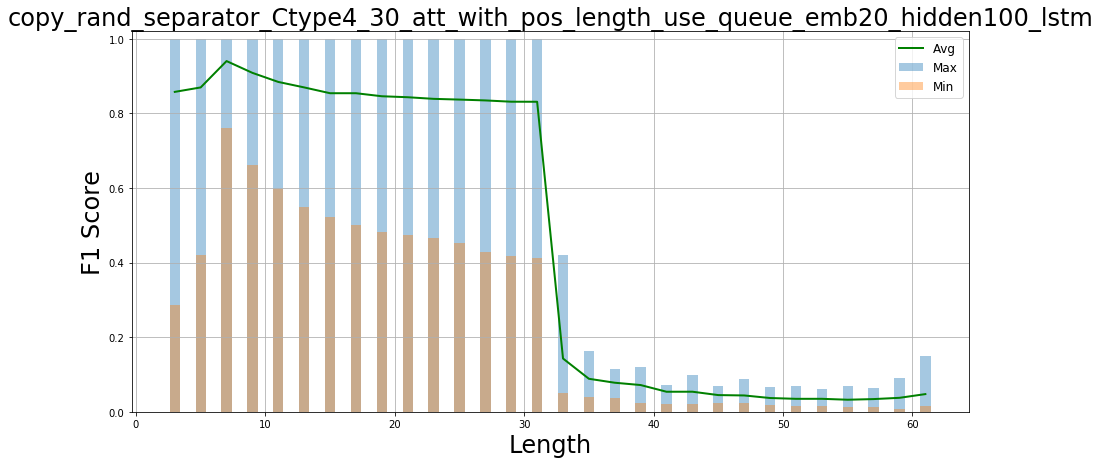

In [6]:
plt.figure(figsize=(15,7))
plt.bar(lengths, f1_score_max, LineWidth=2, label="Max", alpha=0.4)
plt.bar(lengths, f1_score_min, LineWidth=2, label="Min", alpha=0.4)
plt.plot(lengths, f1_score_avg, '-g', LineWidth=2, label="Avg")

plt.title(save_path + "_" + rnn, fontsize=24)
plt.legend(loc="best", fontsize=12)
plt.xlabel('Length', fontsize=24)
plt.ylabel('F1 Score', fontsize=24)
plt.ylim([0, 1.02])
plt.grid()
plt.savefig(fig_path + '/length_to_f1_score.png',format='png',bbox_inches='tight',dpi=300)

In [7]:
print(f1_score_avg)

[0.8575910364145658, 0.8694737694845808, 0.9401399106556608, 0.9085245844370778, 0.8842015841936022, 0.8695212539664456, 0.8539550901141946, 0.8539749647677839, 0.8458401196271478, 0.8432338686517877, 0.8388704054271032, 0.8369080119240134, 0.8346510628034565, 0.8312042256339328, 0.8310723532700411, 0.14278139913783675, 0.0885068056471682, 0.07792629741518328, 0.071709298157505, 0.05374065127534744, 0.05384989706518093, 0.04480011136886085, 0.043829464141107395, 0.03694780491767756, 0.0347806854111163, 0.03480880839685154, 0.03236180333335232, 0.03409415325326707, 0.037476520591949176, 0.04743755428651517]


In [8]:
print(sum(f1_score_avg,0.0)/len(f1_score_avg))

0.45780711652567707
